# **CNN + BiGRU + Attention**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
zip_path = '/content/drive/MyDrive/semester_project_2.3/mit-bih-atrial-fibrillation-database-1.0.0.zip'
!cp "{zip_path}" /content/afdb.zip
!mkdir -p afdb_data
!unzip -q /content/afdb.zip -d afdb_data
!pip install wfdb

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
replace afdb_data/files/08455.hea? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [29]:
import os
import zipfile
import random
import numpy as np
import wfdb
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#### Create included patients list

In [ ]:
# patient records are in data_dir
data_dir = "/content/afdb_data/files"
all_files = os.listdir(data_dir)

# patients with .dat files
dat_files = [f for f in all_files if f.endswith('.dat')]
dat_patients = sorted([f.replace('.dat', '') for f in dat_files])

# after inspection in other notebooks, these are the excluded patients
excluded_patients = ['00735', '03665', '04043', '08405', '08434', '07859']

# final included patients list
included_patients = sorted([p for p in dat_patients if p not in excluded_patients])

print(f"Total included patients: {len(included_patients)}")
print(included_patients)

Total included patients: 19
['04015', '04048', '04126', '04746', '04908', '04936', '05091', '05121', '05261', '06426', '06453', '06995', '07162', '07879', '07910', '08215', '08219', '08378', '08455']


#### Make sure all of our patients contain AFib labels

In [7]:
# making sure all of our patients have AFib windows
# and aren't strictly AFL/J patients
print("Confirming all patients have AFib windows\n")

patient_has_af = {}
for rec in included_patients:
    path = os.path.join(data_dir, rec)
    ann = wfdb.rdann(path, 'atr')
    # if patient has one AFib window, mark them as AFib
    has_af = any('(AFIB' in s for s in ann.aux_note)
    patient_has_af[rec] = int(has_af)

# create lists
af_patients = [p for p, v in patient_has_af.items() if v == 1]
non_af_patients = [p for p, v in patient_has_af.items() if v == 0]

# print results
print(f"Total patients with AFIB episodes: {len(af_patients)}")
print(af_patients)
print(f"\nTotal patients without AFIB episodes: {len(non_af_patients)}")
print(non_af_patients)

Confirming all patients have AFib windows

Total patients with AFIB episodes: 19
['04015', '04048', '04126', '04746', '04908', '04936', '05091', '05121', '05261', '06426', '06453', '06995', '07162', '07879', '07910', '08215', '08219', '08378', '08455']

Total patients without AFIB episodes: 0
[]


#### Split into test and val sets

In [15]:
# reproducibility
random.seed(42)
random.shuffle(af_patients)

# 80-20 train/val split
# based only on af_patients since they all belong there
split_af = int(0.8 * len(af_patients))

train_patients = af_patients[:split_af]
val_patients   = af_patients[split_af:]

random.shuffle(train_patients)
random.shuffle(val_patients)

# print final splits
print("Patient split summary:")
print(f"Total train patients: {len(train_patients)}")
print(f"Total val patients: {len(val_patients)}\n")
print(f"Train patients:\n{train_patients}")
print(f"Val patients:\n{val_patients}")

Patient split summary:
Total train patients: 15
Total val patients: 4

Train patients:
['07162', '07879', '05091', '04908', '04746', '08215', '05121', '04015', '04936', '07910', '06426', '06453', '04126', '05261', '04048']
Val patients:
['08219', '08378', '06995', '08455']


#### Apply per-window preprocessing

In [16]:
# initialize constants and arrays
FS = 250
WINDOW_SECONDS = 10
WINDOW_SIZE = WINDOW_SECONDS * FS
STEP_SIZE = WINDOW_SIZE // 2  # 50% overlap between windows
total_windows = 0
dropped_windows = 0

X_train, y_train = [], []
X_val, y_val = [], []

print("Starting window preprocessing")
for rec in tqdm(included_patients):
    # get signal
    path = os.path.join(data_dir, rec)
    record = wfdb.rdrecord(path)
    ann = wfdb.rdann(path, 'atr')
    signal = record.p_signal
    ann_samples = ann.sample
    ann_symbols = ann.aux_note

    # create mask, N:0 - AFib:1
    label_mask = np.full(len(signal), -1, dtype=np.int8)
    current_label = -1
    for i, (sample, label) in enumerate(zip(ann_samples, ann_symbols)):
        if '(AFIB' in label:
            current_label = 1
        elif '(N' in label:
            current_label = 0
        else:
            current_label = -1
        # fill out
        end = ann_samples[i + 1] if i < len(ann_samples) - 1 else len(signal)
        label_mask[sample:end] = current_label

    # slide windows across the signal to extract segments
    for start in range(0, len(signal) - WINDOW_SIZE, STEP_SIZE):
        end = start + WINDOW_SIZE
        seg_labels = label_mask[start:end]

        # drop windows with AFL/J rythm
        if -1 in seg_labels:
            dropped_windows += 1
            continue

        # majority vote to decide final label
        label = 1 if np.sum(seg_labels) > (WINDOW_SIZE / 2) else 0

        # per-window normalization
        seg_signal = signal[start:end]
        seg_signal = (seg_signal - np.mean(seg_signal, axis=0)) / (np.std(seg_signal, axis=0) + 1e-6)

        # noise rejection (in case any value in the window is very big)
        if np.max(np.abs(seg_signal)) > 20:
            dropped_windows += 1
            continue

        # assign to correct split (per patient)
        if rec in train_patients:
            X_train.append(seg_signal)
            y_train.append(label)
        else:
            X_val.append(seg_signal)
            y_val.append(label)

        total_windows += 1

print("\n\nPreprocessing complete")
print(f"Windows kept: {total_windows}")
print(f"Dropped windows: {dropped_windows}")

Starting window preprocessing


100%|██████████| 19/19 [00:57<00:00,  3.01s/it]



Preprocessing complete
Windows kept: 137888
Dropped windows: 1304


#### Modify data so that PyTorch can use it

In [17]:
# prepare arrays for pytorch
X_train = np.array(X_train, dtype=np.float32).transpose(0, 2, 1)
y_train = np.array(y_train, dtype=np.int64)
X_val = np.array(X_val, dtype=np.float32).transpose(0, 2, 1)
y_val = np.array(y_val, dtype=np.int64)

print(f"Train shape: {X_train.shape} with {np.mean(y_train)*100:.1f}% AFib")
print(f"Val shape: {X_val.shape} with {np.mean(y_val)*100:.1f}% AFib")

Train shape: (108763, 2, 2500) with 37.6% AFib
Val shape: (29125, 2, 2500) with 40.1% AFib


In [18]:
# handles windows, optionally applies augmentation and returns as PyTorch sensors
class ECGDataset_CNNRNN(Dataset):
    def __init__(self, X, y, augment=False):
        self.X = X
        self.y = y
        self.augment = augment

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        signal = self.X[idx].copy()
        label = self.y[idx]

        if self.augment:
            # Gaussian noise
            if np.random.rand() > 0.4:
                noise = np.random.normal(0, 0.05, signal.shape)
                signal += noise

            # amplitude scaling
            if np.random.rand() > 0.4:
                scale = np.random.uniform(0.8, 1.2)
                signal *= scale

            # channel dropout
            if signal.shape[0] == 2 and np.random.rand() > 0.5:
                ch = np.random.randint(0, 2)
                signal[ch] = 0.0

        return torch.tensor(signal, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

In [19]:
# create PyTorch dataloaders
BATCH_SIZE = 64
train_dataset = ECGDataset_CNNRNN(X_train, y_train, augment=True)
val_dataset = ECGDataset_CNNRNN(X_val, y_val, augment=False)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print("DataLoaders ready")

DataLoaders ready


## Define model

In [20]:
# model definition

class TemporalAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attn = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.Tanh(),
            nn.Linear(hidden_dim // 2, 1)
        )

    def forward(self, x):
        weights = torch.softmax(self.attn(x), dim=1)
        context = torch.sum(weights * x, dim=1)
        return context

class CNN_BiGRU_Attention(nn.Module):
    def __init__(self, input_channels=2, num_classes=2):
        super().__init__()

        # CNN
        self.cnn = nn.Sequential(
            nn.Conv1d(input_channels, 64, kernel_size=15, stride=2, padding=7),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.MaxPool1d(2),

            nn.Conv1d(64, 128, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.MaxPool1d(2),
        )

        # BiGRU
        self.gru = nn.GRU(
            input_size=128,
            hidden_size=64,
            num_layers=2,
            batch_first=True,
            bidirectional=True,
            dropout=0.3
        )

        # Attention
        self.attention = TemporalAttention(hidden_dim=128)

        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.cnn(x)
        x = x.permute(0, 2, 1)

        gru_out, _ = self.gru(x)
        context = self.attention(gru_out)

        logits = self.classifier(context)
        return logits

### Initialize model

In [21]:
# select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# initialize model
model = CNN_BiGRU_Attention(input_channels=2, num_classes=2).to(device)

# compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

# choose loss and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

print("Model is ready for training")

Model is ready for training


### Train model

In [22]:
# train model
NUM_EPOCHS = 20
best_val_acc = 0.0
history = {
    'train_loss': [], 'val_loss': [],
    'train_acc': [], 'val_acc': [],
    'train_recall': [], 'val_recall': [],
    'train_f1': [], 'val_f1': []
}

for epoch in range(NUM_EPOCHS):
    # -----
    # train
    # -----
    model.train()
    train_loss = 0.0
    train_preds, train_labels = [], []

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * x.size(0)
        train_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
        train_labels.extend(y.cpu().numpy())

    # compute metrics
    train_loss /= len(train_dataset)
    train_acc = accuracy_score(train_labels, train_preds)
    train_recall = recall_score(train_labels, train_preds)
    train_f1 = f1_score(train_labels, train_preds)

    # ----------
    # validation
    # ----------
    model.eval()
    val_loss = 0.0
    val_preds, val_labels = [], []

    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits, y)

            val_loss += loss.item() * x.size(0)
            val_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            val_labels.extend(y.cpu().numpy())

    # compute metrics
    val_loss /= len(val_dataset)
    val_acc = accuracy_score(val_labels, val_preds)
    val_recall = recall_score(val_labels, val_preds)
    val_f1 = f1_score(val_labels, val_preds)

    scheduler.step(val_loss)

    # save metrics
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    history['train_recall'].append(train_recall)
    history['val_recall'].append(val_recall)
    history['train_f1'].append(train_f1)
    history['val_f1'].append(val_f1)

    # print epoch results
    print(f"Epoch {epoch+1}")
    print(f"Train | Loss={train_loss:.4f}, Acc={train_acc:.4f}, Recall={train_recall:.4f}, F1={train_f1:.4f}")
    print(f"Val   | Loss={val_loss:.4f}, Acc={val_acc:.4f}, Recall={val_recall:.4f}, F1={val_f1:.4f}")

    # save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_cnn_bigru_attention.pth")
        print("Found new best model!")

    print("\n")

print("\nTraining has ended")

Epoch 1
Train | Loss=0.2484, Acc=0.8992, Recall=0.8941, F1=0.8698
Val   | Loss=0.2008, Acc=0.9512, Recall=0.9374, F1=0.9391
Found new best model!


Epoch 2
Train | Loss=0.0821, Acc=0.9730, Recall=0.9734, F1=0.9645
Val   | Loss=0.2431, Acc=0.9489, Recall=0.8879, F1=0.9332


Epoch 3
Train | Loss=0.0564, Acc=0.9821, Recall=0.9821, F1=0.9764
Val   | Loss=0.1811, Acc=0.9704, Recall=0.9452, F1=0.9625
Found new best model!


Epoch 4
Train | Loss=0.0474, Acc=0.9852, Recall=0.9843, F1=0.9804
Val   | Loss=0.2608, Acc=0.9493, Recall=0.8852, F1=0.9334


Epoch 5
Train | Loss=0.0417, Acc=0.9871, Recall=0.9857, F1=0.9829
Val   | Loss=0.2125, Acc=0.9713, Recall=0.9579, F1=0.9640
Found new best model!


Epoch 6
Train | Loss=0.0370, Acc=0.9891, Recall=0.9879, F1=0.9856
Val   | Loss=0.1760, Acc=0.9783, Recall=0.9610, F1=0.9726
Found new best model!


Epoch 7
Train | Loss=0.0344, Acc=0.9898, Recall=0.9887, F1=0.9865
Val   | Loss=0.1797, Acc=0.9755, Recall=0.9693, F1=0.9695


Epoch 8
Train | Loss=0.0321, A

### Evaluate model on windows

Window level classification report:
              precision    recall  f1-score   support

      Normal       0.97      0.99      0.98     17435
        AFIB       0.98      0.96      0.97     11690

    accuracy                           0.98     29125
   macro avg       0.98      0.98      0.98     29125
weighted avg       0.98      0.98      0.98     29125



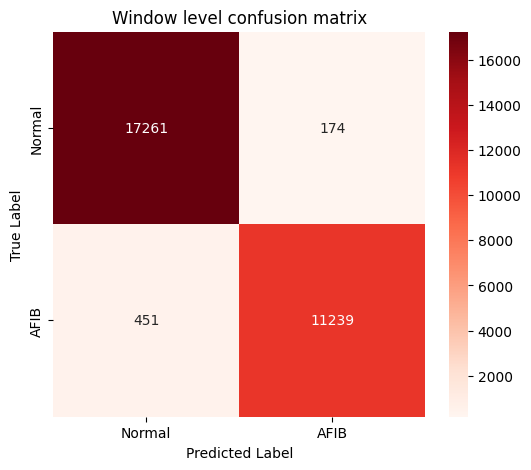

In [23]:
# load best model
model.load_state_dict(torch.load("best_cnn_bigru_attention.pth"))
model.eval()

# predictions and GT
all_preds, all_labels = [], []

with torch.no_grad():
    for x, y in val_loader:
        x = x.to(device)
        logits = model(x)
        preds = torch.argmax(logits, dim=1).cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(y.numpy())

# classification report
print("Window level classification report:")
print(classification_report(all_labels, all_preds, target_names=['Normal', 'AFIB']))

# confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=['Normal','AFIB'], yticklabels=['Normal','AFIB'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Window level confusion matrix')
plt.show()

#### Smoothing function

In [24]:
def smooth_predictions(probs, window_size=9):
    kernel = np.ones(window_size) / window_size
    smoothed = np.convolve(probs, kernel, mode='same')
    pad = window_size // 2
    smoothed[:pad] = probs[:pad]
    smoothed[-pad:] = probs[-pad:]
    return smoothed

### Evaluate model on patients

In [25]:
# evaluate model on val patients instead of windows
global_true = []
global_pred = []

for patient_id in tqdm(val_patients):
    # load signal
    path = os.path.join(data_dir, patient_id)
    record = wfdb.rdrecord(path)
    ann = wfdb.rdann(path, 'atr')
    signal = record.p_signal

    # label mask
    label_mask = np.full(len(signal), -1, dtype=int)
    current_label = -1
    for i, (samp, sym) in enumerate(zip(ann.sample, ann.aux_note)):
        if '(AFIB' in sym:
            current_label = 1
        elif '(N' in sym:
            current_label = 0
        else:
            current_label = -1

        end = ann.sample[i+1] if i < len(ann.sample)-1 else len(signal)
        label_mask[samp:end] = current_label

    # slide non-overlapping windows over signal
    windows, labels = [], []
    for start in range(0, len(signal) - WINDOW_SIZE, WINDOW_SIZE):
        end = start + WINDOW_SIZE
        seg_labels = label_mask[start:end]

        if -1 in seg_labels:
            continue

        label = 1 if np.sum(seg_labels) > (WINDOW_SIZE / 2) else 0

        # normalize and reject noise
        seg = signal[start:end]
        seg = (seg - seg.mean(axis=0)) / (seg.std(axis=0) + 1e-6)
        if np.max(np.abs(seg)) > 20:
            continue

        windows.append(seg)
        labels.append(label)

    if len(windows) == 0:
        continue

    # run model
    Xp = np.array(windows, dtype=np.float32).transpose(0, 2, 1)
    Xt = torch.tensor(Xp).to(device)
    with torch.no_grad():
        probs = torch.softmax(model(Xt), dim=1)[:, 1].cpu().numpy()

    # smooth probabilities
    smooth_probs = smooth_predictions(probs, window_size=9)
    preds = (smooth_probs > 0.4).astype(int)

    # collect results
    global_true.extend(labels)
    global_pred.extend(preds)

100%|██████████| 4/4 [00:08<00:00,  2.02s/it]


Patient level classification report
              precision    recall  f1-score   support

      Normal       0.99      0.98      0.98      8717
        AFIB       0.98      0.98      0.98      5846

    accuracy                           0.98     14563
   macro avg       0.98      0.98      0.98     14563
weighted avg       0.98      0.98      0.98     14563



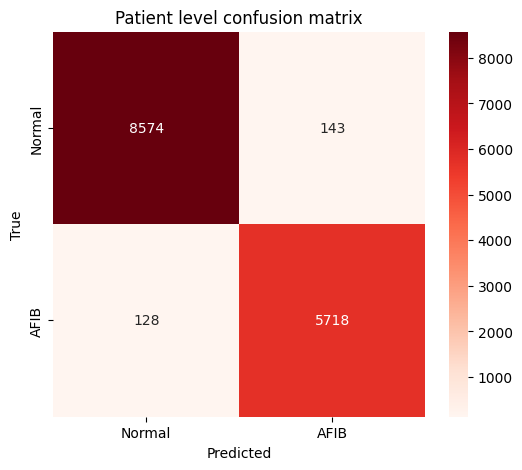

In [26]:
# classification report
print("Patient level classification report")
print(classification_report(global_true, global_pred, target_names=['Normal', 'AFIB']))

# confusion matrix
cm = confusion_matrix(global_true, global_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=['Normal', 'AFIB'], yticklabels=['Normal', 'AFIB'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Patient level confusion matrix")
plt.show()


## Perform a LOPO evaluation on our patients (leave one patient out)

Full LOPO: 100%|██████████| 19/19 [1:00:14<00:00, 190.22s/it]



LOPO results

              precision    recall  f1-score   support

      Normal       0.89      0.93      0.91     42623
        AFIB       0.88      0.82      0.85     26319

    accuracy                           0.89     68942
   macro avg       0.89      0.87      0.88     68942
weighted avg       0.89      0.89      0.89     68942



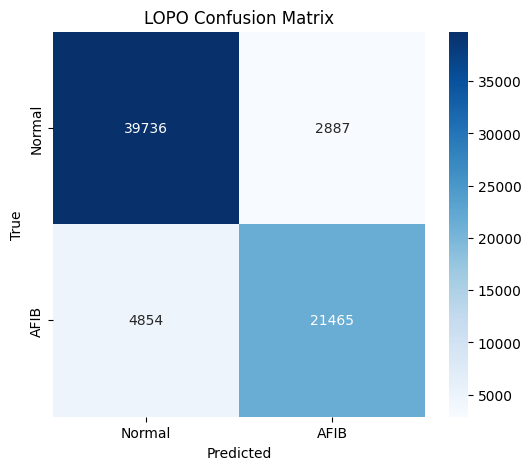

In [31]:
WINDOW_SECONDS = 10
FS = 250
WINDOW_SIZE = WINDOW_SECONDS * FS

NUM_EPOCHS = 10
BATCH_SIZE = 64

all_true, all_pred = [], []

# Loop over each patient as the test patient
for test_patient in tqdm(included_patients, desc="Full LOPO"):
    # Split remaining patients into training and validation
    train_patients = [p for p in included_patients if p != test_patient]
    train_patients, val_patients = train_test_split(train_patients, test_size=3, random_state=42)

    # Collect train windows & labels
    X_train, y_train = [], []
    for pid in train_patients:
        path = os.path.join(data_dir, pid)
        record = wfdb.rdrecord(path)
        ann = wfdb.rdann(path, 'atr')
        signal = record.p_signal

        # Create label mask
        label_mask = np.full(len(signal), -1, dtype=int)
        current_label = -1
        for i, (samp, sym) in enumerate(zip(ann.sample, ann.aux_note)):
            if '(AFIB' in sym:
                current_label = 1
            elif '(N' in sym:
                current_label = 0
            else:
                current_label = -1
            end = ann.sample[i+1] if i < len(ann.sample)-1 else len(signal)
            label_mask[samp:end] = current_label

        # Slide windows
        for start in range(0, len(signal) - WINDOW_SIZE, WINDOW_SIZE):
            end = start + WINDOW_SIZE
            seg_labels = label_mask[start:end]
            if -1 in seg_labels:
                continue
            label = 1 if np.sum(seg_labels) > (WINDOW_SIZE / 2) else 0
            seg = signal[start:end]
            seg = (seg - seg.mean(axis=0)) / (seg.std(axis=0) + 1e-6)
            if np.max(np.abs(seg)) > 20:
                continue
            X_train.append(seg)
            y_train.append(label)

    # Same for validation
    X_val, y_val = [], []
    for pid in val_patients:
        path = os.path.join(data_dir, pid)
        record = wfdb.rdrecord(path)
        ann = wfdb.rdann(path, 'atr')
        signal = record.p_signal

        label_mask = np.full(len(signal), -1, dtype=int)
        current_label = -1
        for i, (samp, sym) in enumerate(zip(ann.sample, ann.aux_note)):
            if '(AFIB' in sym:
                current_label = 1
            elif '(N' in sym:
                current_label = 0
            else:
                current_label = -1
            end = ann.sample[i+1] if i < len(ann.sample)-1 else len(signal)
            label_mask[samp:end] = current_label

        for start in range(0, len(signal) - WINDOW_SIZE, WINDOW_SIZE):
            end = start + WINDOW_SIZE
            seg_labels = label_mask[start:end]
            if -1 in seg_labels:
                continue
            label = 1 if np.sum(seg_labels) > (WINDOW_SIZE / 2) else 0
            seg = signal[start:end]
            seg = (seg - seg.mean(axis=0)) / (seg.std(axis=0) + 1e-6)
            if np.max(np.abs(seg)) > 20:
                continue
            X_val.append(seg)
            y_val.append(label)

    # Convert to arrays
    X_train = np.array(X_train, dtype=np.float32).transpose(0, 2, 1)
    y_train = np.array(y_train, dtype=np.int64)
    X_val = np.array(X_val, dtype=np.float32).transpose(0, 2, 1)
    y_val = np.array(y_val, dtype=np.int64)

    train_dataset = ECGDataset_CNNRNN(X_train, y_train, augment=True)
    val_dataset = ECGDataset_CNNRNN(X_val, y_val, augment=False)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

    # Initialize model fresh each iteration
    model = CNN_BiGRU_Attention(input_channels=2, num_classes=2).to(device)

    # Class weights
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
    class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

    # Training loop
    best_val_acc = 0
    for epoch in range(NUM_EPOCHS):
        model.train()
        train_loss = 0
        train_preds, train_labels = [], []

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * x.size(0)
            train_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            train_labels.extend(y.cpu().numpy())

        train_loss /= len(train_dataset)
        train_acc = accuracy_score(train_labels, train_preds)

        # Validation
        model.eval()
        val_loss = 0
        val_preds, val_labels = [], []

        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                logits = model(x)
                loss = criterion(logits, y)

                val_loss += loss.item() * x.size(0)
                val_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
                val_labels.extend(y.cpu().numpy())

        val_loss /= len(val_dataset)
        val_acc = accuracy_score(val_labels, val_preds)
        scheduler.step(val_loss)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f"best_model_LOPO_{test_patient}.pth")

    # --- Evaluate on the test patient ---
    path = os.path.join(data_dir, test_patient)
    record = wfdb.rdrecord(path)
    ann = wfdb.rdann(path, 'atr')
    signal = record.p_signal

    label_mask = np.full(len(signal), -1, dtype=int)
    current_label = -1
    for i, (samp, sym) in enumerate(zip(ann.sample, ann.aux_note)):
        if '(AFIB' in sym:
            current_label = 1
        elif '(N' in sym:
            current_label = 0
        else:
            current_label = -1
        end = ann.sample[i+1] if i < len(ann.sample)-1 else len(signal)
        label_mask[samp:end] = current_label

    windows, labels = [], []
    for start in range(0, len(signal) - WINDOW_SIZE, WINDOW_SIZE):
        end = start + WINDOW_SIZE
        seg_labels = label_mask[start:end]
        if -1 in seg_labels:
            continue
        label = 1 if np.sum(seg_labels) > (WINDOW_SIZE / 2) else 0
        seg = signal[start:end]
        seg = (seg - seg.mean(axis=0)) / (seg.std(axis=0)+1e-6)
        if np.max(np.abs(seg)) > 20:
            continue
        windows.append(seg)
        labels.append(label)

    X_test = np.array(windows, dtype=np.float32).transpose(0, 2, 1)
    Xt = torch.tensor(X_test).to(device)

    # Load best model
    model.load_state_dict(torch.load(f"best_model_LOPO_{test_patient}.pth"))
    model.eval()

    with torch.no_grad():
        probs = torch.softmax(model(Xt), dim=1)[:,1].cpu().numpy()
    smooth_probs = smooth_predictions(probs, window_size=9)
    preds = (smooth_probs > 0.4).astype(int)

    all_true.extend(labels)
    all_pred.extend(preds)

# Final LOPO metrics
print("\nLOPO results\n")
print(classification_report(all_true, all_pred, target_names=['Normal','AFIB']))
cm = confusion_matrix(all_true, all_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal','AFIB'], yticklabels=['Normal','AFIB'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('LOPO Confusion Matrix')
plt.show()